# Cryptocurrencies prediction

**sujet** : Investir dans les monnaies virtuelles? Élaborer une stratégie prédictive des cours de cryptomonnaies. 

Ce projet a pour but de prédire la valeur des differentes cryptomonnaies existantes et ainsi d'élaborer une stratégie pour déterminer sur quelle(s) cryptomonnaie(s) investir.

Pour ce projet, nous avons utilisé l'api coingecko, qui est une api gratuite et qui permet d'obtenir divers informations sur les cryptomonmaies.

API coingecko : https://www.coingecko.com/api/documentations/v3

# Contexte

## Importation des librairies nécessaires

In [3]:
import numpy as np
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import time
import datetime
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller #Augmented Dickey-Fuller test
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plot

## Acquisition des données

Pour l'acquisition des données, nous avons utilisé la requête suivante : https://api.coingecko.com/api/v3/coins/{cryptocurrency}/market_chart/range?vs_currency={devise}usd&from={date_debut}&to={date_fin}

* cryptocurrency : la cryptomonnaie que l'on souhaite avoir des informations
* devise: valeur de la cryptomonnaie pour cette devise, ex: usd (pour dollars)
* date_debut : date de début (en timestamp) de l'acquisition des données
* date_fin : date de fin (en timestamp) de l'acquisition des données

In [4]:
start_date = "20/11/2020"
end_date = "25/11/2020"
start_timestamp = int(time.mktime(datetime.datetime.strptime(start_date, "%d/%m/%Y").timetuple()))
end_timestamp  = int(time.mktime(datetime.datetime.strptime(end_date, "%d/%m/%Y").timetuple()))

print(start_timestamp, end_timestamp)

1605826800 1606258800


In [5]:
currency="bitcoin"
url = 'https://api.coingecko.com/api/v3/coins/'+currency+'/market_chart/range?'
parameters = {
    'vs_currency':'usd',
    'from':start_timestamp,
    'to':end_timestamp
}

session = Session()

try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    mypath = os.path.abspath('')
    path_to_save = str(mypath) + '/../data/'
    df = pd.DataFrame(data["prices"])
    file_name = "data.csv"
    df.to_csv(os.path.join(path_to_save, file_name))
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

In [6]:
csv_file_name = '../data/data.csv' #please put the name of the csv file you want to read
data = pd.read_csv(csv_file_name, index_col=[0],sep=',', encoding="utf-8")
data.iloc[:5] # we display the first 5 rows

,0,1
0,1605827332571,17878.504943
1,1605831039446,17822.996753
2,1605834375784,17775.271933
3,1605838402527,17940.763174
4,1605842903104,17987.234295


In [7]:
data.columns = ['time', 'price']

In [8]:
data['time'] = data['time'].astype(str).str[:-3].astype(np.int64)

In [9]:
data

,time,price
0,1605827332,17878.504943
1,1605831039,17822.996753
2,1605834375,17775.271933
3,1605838402,17940.763174
4,1605842903,17987.234295
...,...,...
115,1606241189,19135.703235
116,1606245256,19192.871932
117,1606249215,19139.487099
118,1606252332,19017.571635


In [10]:
data['time'] = pd.to_datetime(data['time'], unit='s')

In [11]:
data

,time,price
0,2020-11-19 23:08:52,17878.504943
1,2020-11-20 00:10:39,17822.996753
2,2020-11-20 01:06:15,17775.271933
3,2020-11-20 02:13:22,17940.763174
4,2020-11-20 03:28:23,17987.234295
...,...,...
115,2020-11-24 18:06:29,19135.703235
116,2020-11-24 19:14:16,19192.871932
117,2020-11-24 20:20:15,19139.487099
118,2020-11-24 21:12:12,19017.571635


In [12]:
data = data.set_index('time')

## Affichage de la donnée

In [13]:
def plotting(serie, title):
    plot.figure(figsize=(15,5))
    plot.plot(serie)
    plot.xlabel('Date', fontsize=12)
    plot.ylabel('Price in USD', fontsize=12)
    plot.title(title, fontsize=15)
    plot.show()

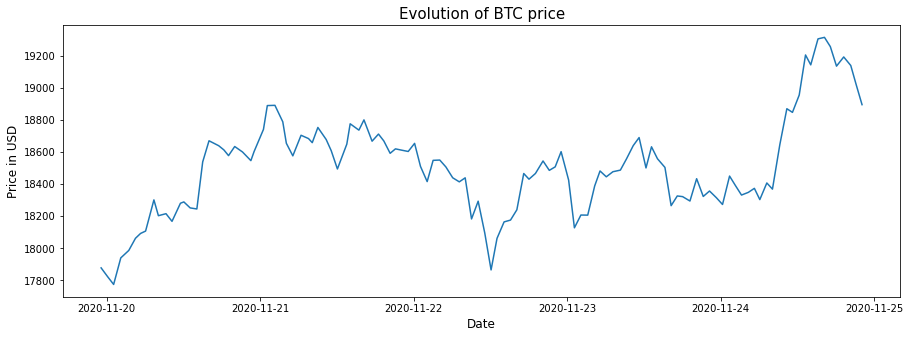

In [14]:
plotting(data, "Evolution of BTC price")

## Test de la stationnarité

Pour avoir un bon modèle de prédiction, il faut que les observations soient stationnaires (c'est à dire que la moyenne et la variance sont constantes le long des observations).

Une des méthodes est d'utilisé le test augmenté de dickey fuller (adf). Pour que les observations soient stationnaires, il faut que le résultat p du test adf soit inférieur à 0.05.

In [15]:
def ADFtest(serie):
    val = serie.values
    result = adfuller(val)
    print('ADF Statistic: ' + str(result[0])) # the more negative, the more we reject null hypothesis = stationnary
    print('p-value: ' + str(result[1])) # p<0.05 => reject null hypothesis = stationnary

In [16]:
ADFtest(data)

ADF Statistic: -2.3372632719105195
p-value: 0.16023123919483928


On voit que la valeur de p est supérieur à 0.05 donc notre serie n'est pas stationnaire.
Nous allons appliqué une transformation logarithmique à notre serie pour enlever les trops fortes dynamiques qui pourraient y avoir.

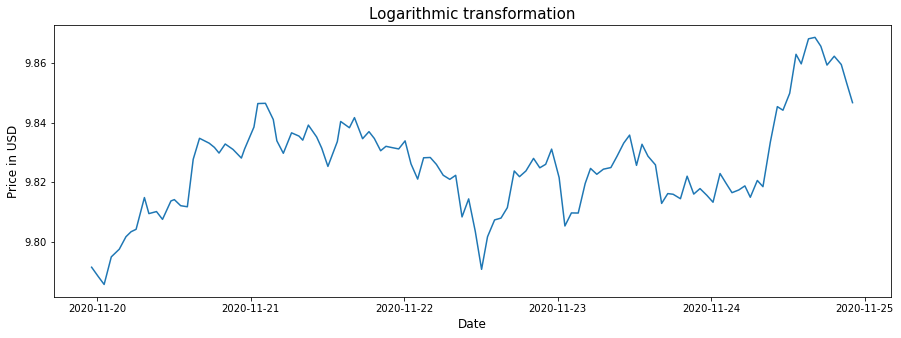

ADF Statistic: -2.363417679071498
p-value: 0.15232874611120006


In [17]:
logTransformed = np.log(data)
plotting(logTransformed,"Logarithmic transformation")
ADFtest(logTransformed)
    

On observe une valeur de p inférieur à celle trouvée précédement mais toujours supérieur à 0.05, donc nous n'avons toujours pas quelque chose de stationnaire.

Nous allons appliquer une autre transformation qui est la difference. Nous allons soustraire l'observation courante avec les observations précédentes. Cette difference permet de supprimer les tendances et les saisons tout en gardant la même moyenne.


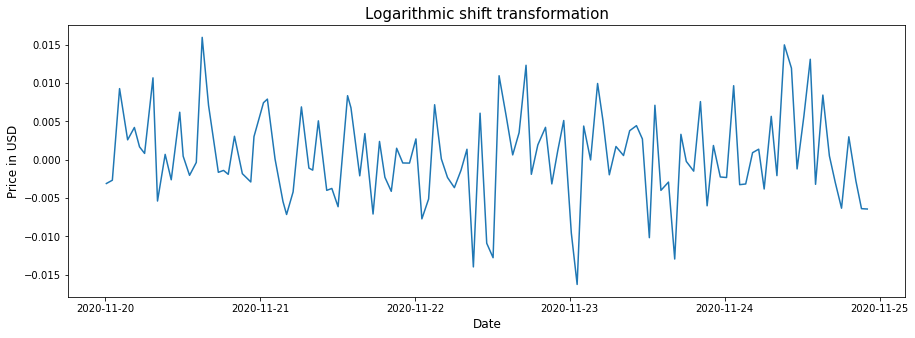

ADF Statistic: -10.726209263388963
p-value: 3.060827635053198e-19


In [18]:
logDiffTransformed = logTransformed - logTransformed.shift()
logDiffTransformed = logDiffTransformed.iloc[1:]
plotting(logDiffTransformed,"Logarithmic shift transformation")

ADFtest(logDiffTransformed)

On voit que nous avons une valeur de p inférieur à 0.05, donc nous avons quelque chose de stationnaire. 

On peut appuyer notre test de stationnarité avec la fonction d'autocorrélation.

## Fonction d'auto corrélation

Ensuite nous allons vérifier si nos observations sont corrélés lors de chaque transformation.

In [19]:
def autocorrelation(serie):
    val = serie.values
    fig = tsaplots.plot_acf(val, lags=10)
    

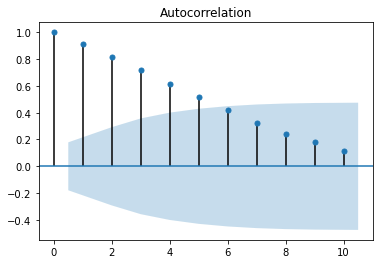

In [20]:
autocorrelation(data)

Nous avons quelque chose de très corrélé. Mais pas stationnaire, il faut que tous les pics soient dans la zone blue.

**Sans transformation, nous pouvons voir que nos observations sont très corrélés**

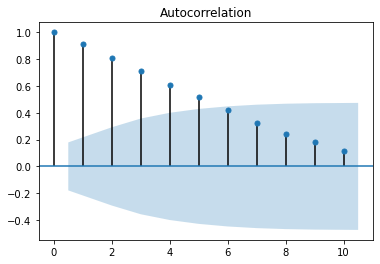

In [21]:
autocorrelation(logTransformed)

**Avec la transformation logarithmique nous avons toujours quelque chose de corrélé**

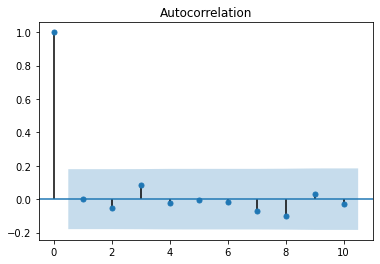

In [22]:
autocorrelation(logDiffTransformed)

Lorsque nous faissons le log et la difference de nos données, nous avons bienn quelque chose de stationnaire, car tous les pics sont dans la zone bleu (rappel: le pic à 0 ne compte pas).

**Et enfin nous pouvons voir que lorsque que l'on applique la transformation logarithmique et la difference, nous cassons la corrélation entre les observations, car tout les pics (excepté le premier sur 0 qui ne compte pas), ne dépassent pas la zone bleu. Cette zone bleu signifie que tous les pics qui ne sortent pas de la zone bleu, sont considérés comme égaux à 0, donc que les observations passés n'ont pas d'effets sur les observations présentes.**

Ensuite, nous allons essayer de trouver le meilleur modèle possible pour prédire notre série

## Modèle auto régressif (AR)

Le modèle auto régressif utilise les précédentes observations pour prédire l'observations suivante.
Pour determiner ce modèle, nous devons determiner combien de valeurs passés ne devont prendre en compte.

Pour cela nous allons utilisé la fonction d'autocorrélation partielle. Dans l'autocorrélation partielle, seulement les corrélations directs sont prises en comptes (les corréalations indirect ne sont pas prises en compte contrairement à l'autocorrélation). Ce qui semble assez naturelle parce que l'on souhaite savoir quelles observations dans le passé ont des effets sur les l'observations présentes.

In [23]:
def partial_autocorrelation(serie):
    val = serie.values
    fig = tsaplots.plot_pacf(val)

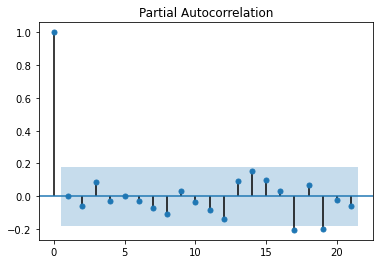

In [24]:
partial_autocorrelation(logDiffTransformed)

Maintenant il faut regarder le nombre de pics important qui sortent de la zone bleu. Il n'y en a aucun pour nous (il y'en a 2 mais ils sont très proche de la zone bleu et ils sont très loin, donc ils doivent être surement dûs à cause d'erreur aléatoire). Et comme nous savons qu'il nous faut au moins un paramêtre, nous allons prendre un modèle AR d'ordre 1.

In [25]:
def AR(serie, p):
    val=serie.values
    model = ARIMA(val, order=(p,0,0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

In [26]:
AR(logDiffTransformed, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  119
Model:                     ARMA(1, 0)   Log Likelihood                 440.314
Method:                       css-mle   S.D. of innovations              0.006
Date:                Wed, 02 Dec 2020   AIC                           -874.628
Time:                        19:41:18   BIC                           -866.291
Sample:                             0   HQIC                          -871.243
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.848      0.397      -0.001       0.002
ar.L1.y    -2.151e-06      0.092  -2.34e-05      1.000      -0.180       0.180
                                    Roots           

## Modèle moyenne mobile (MA)

Dans un modèle à moyenne mobile, les observations dépendent des erreurs passées.
Pour determiner ce modèle, nous devons determiner combien de valeurs passés nous devons prendre en compte.

Pour cela nous allons utilisé la fonction d'autocorrélation. L'autocorrélation prend en compte les corrélations directs et indirects.

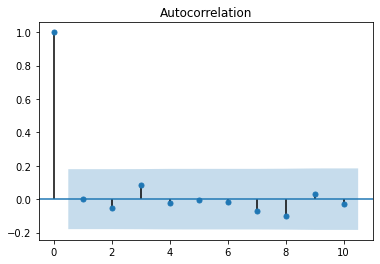

In [27]:
autocorrelation(logDiffTransformed)

Nous sommes normalement sencés prendre pour nombre de valeur pour la modèle à moyenne mobile le nombre de pics important qui sortent de la zone blue, sauf que comme il n'y en a aucun, et que nous savons qu'il en faut au moins un, nous allons prendre une seul paramètre. Nous avons donc un modèle à moyenne mobile d'ordre 1.

In [28]:
def MA(serie, q):
    val=serie.values
    model = ARIMA(val, order=(0,0,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

In [29]:
MA(logDiffTransformed, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  119
Model:                     ARMA(0, 1)   Log Likelihood                 440.314
Method:                       css-mle   S.D. of innovations              0.006
Date:                Wed, 02 Dec 2020   AIC                           -874.628
Time:                        19:41:20   BIC                           -866.291
Sample:                             0   HQIC                          -871.243
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.848      0.397      -0.001       0.002
ma.L1.y     -2.15e-06      0.098   -2.2e-05      1.000      -0.191       0.191
                                    Roots           

## Modèle ARMA

Le modèle ARMA est juste une combinaison du modèle AR et du modèle MA. Nous avons donc un modèle ARMA(1,1)

In [30]:
def ARMA(serie, p,q):
    val=serie.values
    model = ARIMA(val, order=(p,0,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

In [31]:
ARMA(logDiffTransformed, 1, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  119
Model:                     ARMA(1, 1)   Log Likelihood                 441.428
Method:                       css-mle   S.D. of innovations              0.006
Date:                Wed, 02 Dec 2020   AIC                           -874.857
Time:                        19:41:21   BIC                           -863.740
Sample:                             0   HQIC                          -870.343
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.699      0.089   -5.03e-05       0.001
ar.L1.y        0.9407      0.037     25.195      0.000       0.867       1.014
ma.L1.y       -1.0000      0.022    -45.514      0.0

## Modèle ARIMA

Le modèle ARIMA est comme le modèle ARMA sauf que cette fois-ci on ajouté un nouveau paramètre, d. 
d représente le nombre de difference non saisonnère requis pour la stationarité. d permet de rendre des données non stationnaires, sationtionnaires. Nous prenons d = 1 car nous faisons une difference sur de observations d'écart 1 (A(t+1) - A(t)).

In [32]:
def myARIMA(serie, p, d, q):
    val=serie.values
    model = ARIMA(val, order=(p,d,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

In [33]:
myARIMA(logDiffTransformed, 1, 1, 1)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  118
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 433.795
Method:                       css-mle   S.D. of innovations              0.006
Date:                Wed, 02 Dec 2020   AIC                           -859.590
Time:                        19:41:23   BIC                           -848.507
Sample:                             1   HQIC                          -855.090
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.776e-06   1.61e-05     -0.358      0.720   -3.74e-05    2.59e-05
ar.L1.D.y      0.0076      0.093      0.082      0.934      -0.174       0.189
ma.L1.D.y     -1.0000      0.028    -35.332      0.0

## Quel modèle choisir ?
Maintenant que nous avons 4 modèles, quel modèle choisir ?
On peut le choisir selon le  Akaike Information Criterion (AIC) ou le Bayesian Information Criterion (BIC).
Dans notre cas, nous allos choisir le AIC. Il faut donc choisir celui qui a le AIC le plus faible.

| modèle  | AIC      |
| ------- |---------:|
| AR      | -874.628 |
| MA      | -874.628 |
| ARMA    | -874.857 |
| ARIMA   | -859.590 |

Cependant comme on peut le voir, les AIC n'apporte pas grand chose car les AICs sont tous très proches. Il est donc difficile de choisir quel modèle est le mieux pour nous.

Il existe une autre méthode plus simple qui est de directement comparer les erreurs que l'on pourrait avoir sur chaque paramètre de chaque modèle, et nous allons prendre comme modèle celui qui a la plus faible erreur sur ces paramètre comme modèle (colonne std err).

| modèle  | erreur constante | erreur paramètre 1 | erreur paramètre 2 | erreur Totale |
| ------- |---------| ------- |---------| -------:|
| AR      | 0.001  | 0.092 | | 0.093|
| MA      | 0.001 | 0.098| | 0.099|
| ARMA    | 0.000 | 0.037 | 0.022 | 0.059|
| ARIMA   | 1.61e-5 | 0.093 | 0.028| 0.121|

Le modèle ARMA est donc le meilleur modèle car il a l'erreur la plus faible (à noter que le differencing du ARIMA n'a rien apporté)

## Validation du modèle

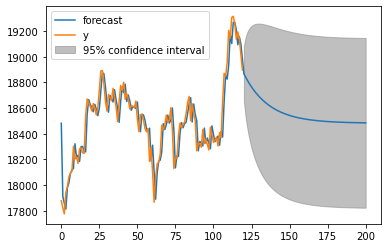

In [34]:
model = ARIMA(data.values, order=(1,0,1))# ARMA
model_fit = model.fit(disp=0)

fig = model_fit.plot_predict(start=0, end=200)

## Vérification des autres modèle


## Modèle AR

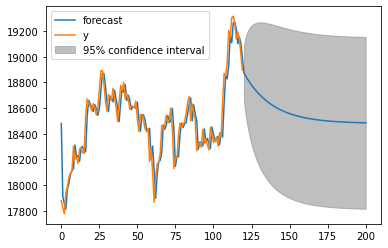

In [35]:
model = ARIMA(data.values, order=(1,0,0))# AR
model_fit = model.fit(disp=0)

fig = model_fit.plot_predict(start=0, end=200)

## Modèle MA

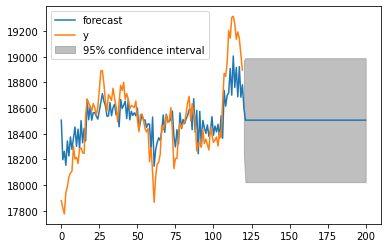

In [36]:
model = ARIMA(data.values, order=(0,0,1))# MA
model_fit = model.fit(disp=0)

fig = model_fit.plot_predict(start=0, end=200)

Notre analyse du meilleur modèle est cohérente, on voit bien que le modèle n'est pas un très bon modèle et que le modèle AR aurait pu remplacer le modèle ARMA si nous n'avions pas fais de modèle ARMA.

# Essai avec plus de données

In [1]:
import numpy as np
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import time
import datetime
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller #Augmented Dickey-Fuller test
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plot

In [21]:
start_date = "01/01/2017"
end_date = "30/11/2020"
start_timestamp = int(time.mktime(datetime.datetime.strptime(start_date, "%d/%m/%Y").timetuple()))
end_timestamp  = int(time.mktime(datetime.datetime.strptime(end_date, "%d/%m/%Y").timetuple()))

print(start_timestamp, end_timestamp)

currency="bitcoin"
url = 'https://api.coingecko.com/api/v3/coins/'+currency+'/market_chart/range?'
parameters = {
    'vs_currency':'usd',
    'from':start_timestamp,
    'to':end_timestamp
}

session = Session()

try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    mypath = os.path.abspath('')
    path_to_save = str(mypath) + '/../data/'
    df = pd.DataFrame(data["prices"])
    file_name = "data.csv"
    df.to_csv(os.path.join(path_to_save, file_name))
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

csv_file_name = '../data/data.csv' #please put the name of the csv file you want to read
data = pd.read_csv(csv_file_name, index_col=[0],sep=',', encoding="utf-8")
data.iloc[len(data)-5:] # we display the first 5 rows

1483225200 1606690800


,0,1
1424,1606262400000,19091.524182
1425,1606348800000,18753.288922
1426,1606435200000,17138.029512
1427,1606521600000,17140.275553
1428,1606608000000,17718.972833


In [22]:
data.columns = ['time', 'price']

data['time'] = data['time'].astype(str).str[:-3].astype(np.int64)

data['time'] = pd.to_datetime(data['time'], unit='s')

data = data.set_index('time')

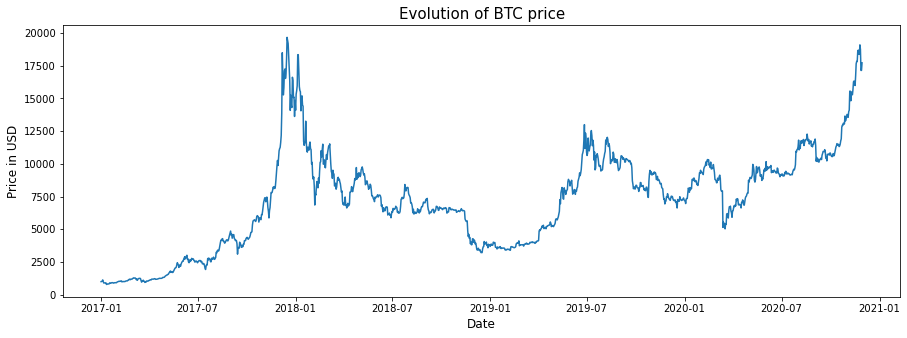

In [23]:
def plotting(serie, title):
    plot.figure(figsize=(15,5))
    plot.plot(serie)
    plot.xlabel('Date', fontsize=12)
    plot.ylabel('Price in USD', fontsize=12)
    plot.title(title, fontsize=15)
    plot.show()

plotting(data, "Evolution of BTC price")

In [24]:
def ADFtest(serie):
    val = serie.values
    result = adfuller(val)
    print('ADF Statistic: ' + str(result[0])) # the more negative, the more we reject null hypothesis = stationnary
    print('p-value: ' + str(result[1])) # p<0.05 => reject null hypothesis = stationnary

ADFtest(data) 

ADF Statistic: -1.832719264496533
p-value: 0.36434269175111145


On voit que la valeu de p est supérieur à 0.05 donc notre serie n'est pas stationnaire.
Nous allons apppliqué un log à notre serie pour enlever les trop grandes valeur qui pouraient biaiser notre serie.

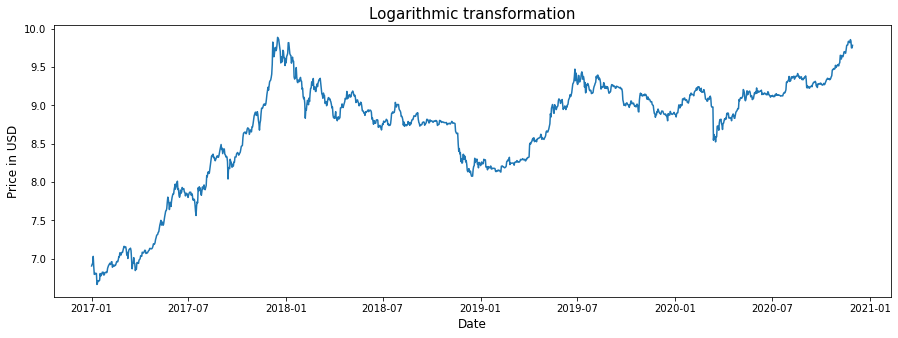

ADF Statistic: -2.031268265553384
p-value: 0.273033530748382


In [25]:
logTransformed = np.log(data)
plotting(logTransformed,"Logarithmic transformation")
ADFtest(logTransformed)

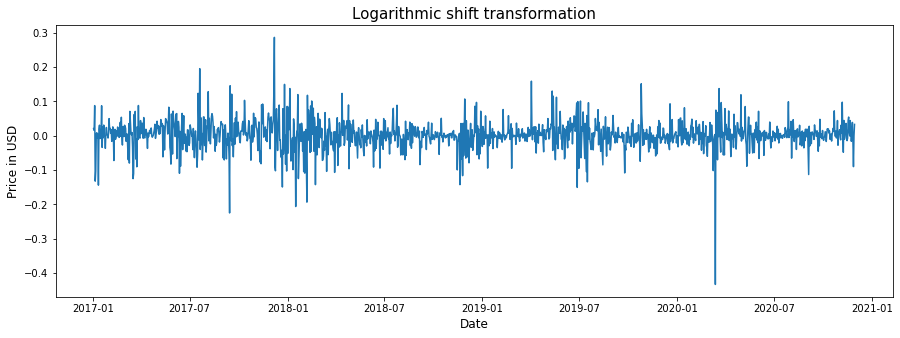

ADF Statistic: -26.072424357234713
p-value: 0.0


In [26]:
logDiffTransformed = logTransformed - logTransformed.shift()
logDiffTransformed = logDiffTransformed.iloc[1:]
plotting(logDiffTransformed,"Logarithmic shift transformation")

ADFtest(logDiffTransformed)

## Fonction d'autocorrélation

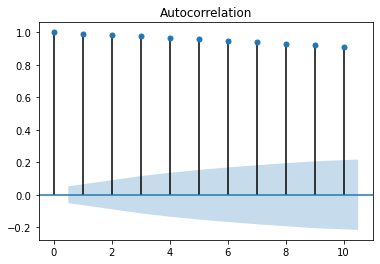

In [27]:
def autocorrelation(serie):
    val = serie.values
    fig = tsaplots.plot_acf(val, lags=10)
    

autocorrelation(data)

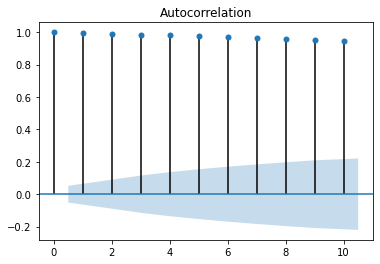

In [28]:
#Nous avons quelque chose de très corrélé. Mais pas stationnaire, il faut que tous les pics soient dans la zone blue.

autocorrelation(logTransformed)

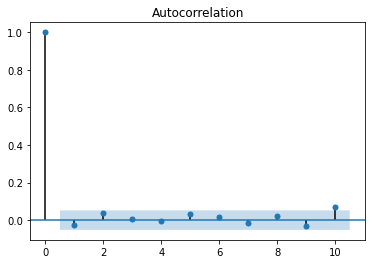

In [29]:
autocorrelation(logDiffTransformed)

## Modèle Auto regressif (AR)

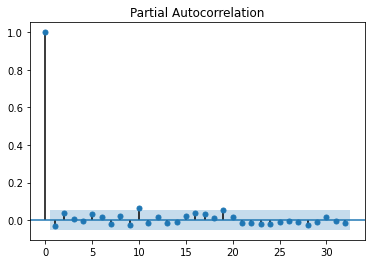

In [30]:
def partial_autocorrelation(serie):
    val = serie.values
    fig = tsaplots.plot_pacf(val)

partial_autocorrelation(logDiffTransformed)

In [31]:
def AR(serie, p):
    val=serie.values
    model = ARIMA(val, order=(p,0,0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

AR(logDiffTransformed, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1428
Model:                     ARMA(1, 0)   Log Likelihood                2486.610
Method:                       css-mle   S.D. of innovations              0.042
Date:                Mon, 30 Nov 2020   AIC                          -4967.219
Time:                        20:44:40   BIC                          -4951.427
Sample:                             0   HQIC                         -4961.321
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.845      0.065      -0.000       0.004
ar.L1.y       -0.0285      0.026     -1.076      0.282      -0.080       0.023
                                    Roots           

## Modèle Moyenne mobile (MA)

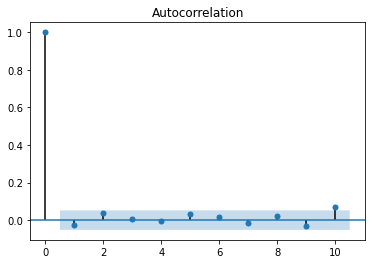

In [32]:
autocorrelation(logDiffTransformed)

Nous sommes normalement sencés prendre pour nombre de valeur pour la modèle à moyenne mobile le nombre de pics important en dehors de la zone blue, sauf que comme il n'y en a aucun, nous allons prendre une seul valeur.



In [33]:
def MA(serie, q):
    val=serie.values
    model = ARIMA(val, order=(0,0,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

MA(logDiffTransformed, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1428
Model:                     ARMA(0, 1)   Log Likelihood                2486.569
Method:                       css-mle   S.D. of innovations              0.042
Date:                Mon, 30 Nov 2020   AIC                          -4967.138
Time:                        20:44:41   BIC                          -4951.346
Sample:                             0   HQIC                         -4961.241
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.843      0.065      -0.000       0.004
ma.L1.y       -0.0265      0.025     -1.039      0.299      -0.076       0.023
                                    Roots           

## Modèle ARMA

In [34]:
def ARMA(serie, p,q):
    val=serie.values
    model = ARIMA(val, order=(p,0,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

ARMA(logDiffTransformed, 1, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1428
Model:                     ARMA(1, 1)   Log Likelihood                2487.390
Method:                       css-mle   S.D. of innovations              0.042
Date:                Mon, 30 Nov 2020   AIC                          -4966.780
Time:                        20:44:42   BIC                          -4945.724
Sample:                             0   HQIC                         -4958.917
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.813      0.070      -0.000       0.004
ar.L1.y       -0.9049      0.078    -11.633      0.000      -1.057      -0.752
ma.L1.y        0.8863      0.084     10.533      0.0

## Modèle ARIMA

Le modèle ARIMA est comme le modèle ARMA sauf que cette fois-ci on ajouté un nouveau paramètre, d. 
d represente le nombre de difference non saisonnère requis pour la stationarité. d permet de rendre des données non stationnaires, sationtionnaires.

**Comment choisir d?**

In [35]:
def myARIMA(serie, p, d, q):
    val=serie.values
    model = ARIMA(val, order=(p,d,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

myARIMA(logDiffTransformed, 1, 1, 1)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1427
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2480.707
Method:                       css-mle   S.D. of innovations              0.042
Date:                Mon, 30 Nov 2020   AIC                          -4953.414
Time:                        20:44:42   BIC                          -4932.361
Sample:                             1   HQIC                         -4945.552
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.261e-08   1.08e-05     -0.002      0.998   -2.12e-05    2.11e-05
ar.L1.D.y     -0.0303      0.027     -1.120      0.263      -0.083       0.023
ma.L1.D.y     -0.9912      0.008   -131.051      0.0

## Quel modèle choisir ?
Maintenant que nous avons 4 modèles, quel modèle choisir ?
On peut le choisir selon le  Akaike Information Criterion (AIC) ou le Bayesian Information Criterion (BIC).
Dans notre cas, nous allos choisir le AIC. Il faut donc choisir celui qui a le AIC le plus faible.

| modèle  | AIC      |
| ------- |---------:|
| AR      | -4744.249 |
| MA      | -4744.481 |
| ARMA    | -4743.711 |
| ARIMA   | -4724.107 |

Le modèle MA est donc le meilleur modèle
### Une autre méthode à faire pour trouver le bon modèle est de calculer l'erreur quadratique moyenne de chaque et de prendre celui qui a la plus faible ⚠️ à faire


## Validation du modèle

1429


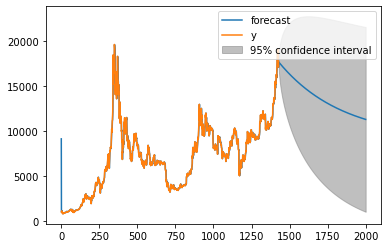

In [36]:
model = ARIMA(data.values, order=(1,0,0))# AR
model_fit = model.fit(disp=0)

print(len(data))

fig = model_fit.plot_predict(start=0, end=2000)